# Modelo Predictivo de Estimación de Presión Arterial

**Procesamiento de la Data:**
Utilizamos la data que esta en .mat, por lo que tenemos que agruparla en mediciones de 10 segundos como se va a utilizar en la realidad. Asi tenemos un numero  de muestras establecido.

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import zipfile
import os
import shutil

import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models

## Se descarga un dataset
Dataset público (no MIMIC-II, sino del UCI Machine Learning Repository).

In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip

--2025-07-03 01:09:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.zip’

data.zip                [           <=>      ]   3.13G  7.63MB/s    in 5m 18s  

2025-07-03 01:14:19 (10.1 MB/s) - ‘data.zip’ saved [3363163675]



## Descompresion de Datos
Se descomprimen los datos y crea una carpeta raw_data, donde se almacenaran los archivos



In [3]:


# Descomprimir en carpeta temporal
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/temp_data')

print("Archivo descomprimido en /content/temp_data")

# Crear carpeta raw_data si no existe
os.makedirs('/content/raw_data', exist_ok=True)

# Mover todo lo descomprimido a raw_data
for root, dirs, files in os.walk('/content/temp_data'):
    for file in files:
        src = os.path.join(root, file)
        dst = os.path.join('/content/raw_data', file)
        shutil.move(src, dst)

print("Archivos movidos a /content/raw_data")

# (Opcional) Verificar los archivos
print("\Archivos en /content/raw_data:")
for f in os.listdir('/content/raw_data'):
    print(f)

Archivo descomprimido en /content/temp_data
Archivos movidos a /content/raw_data
\Archivos en /content/raw_data:
._Part_1.mat
._Part_3.mat
Part_2.mat
Part_1.mat
Part_3.mat
._Part_2.mat
._Part_4.mat
Part_4.mat


## Funciones para Preprocesamiento
Se declaran funciones que seran empleadas para procesar los datos

In [4]:
#lleva cada segmento a un rango de [0,1]
def normalize(segment):
    min_val = np.min(segment)
    max_val = np.max(segment)
    if np.isclose(max_val, min_val):
        return np.zeros_like(segment)
    return (segment - min_val) / (max_val - min_val)


def bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=125, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

#Corta la señal en ventanas de 1024 muestras (8.2 s a 125 Hz).
#Usa stride de 128
def segmentar(signal, bp, segment_length=1024, stride=128):
    X, Y = [], []
    # Aplicar filtro pasa banda a la señal PPG
    signal = bandpass_filter(signal)
    for i in range(0, len(signal) - segment_length + 1, stride):
        ppg_seg = signal[i:i+segment_length]
        abp_seg = bp[i:i+segment_length]

        # 👉 VALIDACIÓN OPCIONAL: descartar segmentos planos o ruidosos
        # if np.std(ppg_seg) < 0.01 or np.std(abp_seg) < 0.01:
        #     continue


        #Normaliza el segmento
        ppg_seg = normalize(ppg_seg)
        abp_seg = normalize(abp_seg)
        X.append(ppg_seg)
        Y.append(abp_seg)
    return np.array(X), np.array(Y)

Se procesan los datos

In [5]:



#definicion de archivos de entrada
archivos = ['raw_data/Part_1.mat', 'raw_data/Part_2.mat', 'raw_data/Part_3.mat', 'raw_data/Part_4.mat']
output_dir = 'segmentos_guardados'
os.makedirs(output_dir, exist_ok=True)

segment_count = 0
registro_procesado = 0

for archivo in archivos:
    grupo_id = os.path.splitext(os.path.basename(archivo))[0]
    print(f'\Procesando: {archivo}')

    with h5py.File(archivo, 'r') as f:
      #se verifica que el grupo exista
        if grupo_id not in f:
            print(f'Grupo {grupo_id} no encontrado en {archivo}')
            continue

        registros = f[grupo_id]
        print(f'Total registros en {grupo_id}: {len(registros)}')

        for i in tqdm(range(len(registros)), desc=f'{grupo_id} registros'):
            try:
                ref = registros[i][0]
                record = f[ref][()]

                #se descarca si no es el formato esperado
                if record.ndim != 2 or record.shape[1] < 2:
                    print(f'Registro {i} inválido: forma {record.shape}')
                    continue
                #extrae la columna 0 como señal ppg y la columna 1 como presion arterial
                signal = record[:, 0]
                bp = record[:, 1]

                X_seg, Y_seg = segmentar(signal, bp)
                if X_seg.size > 0:
                    np.save(os.path.join(output_dir, f'X_seg_{segment_count}.npy'),
                            X_seg[..., np.newaxis].astype(np.float32))
                    np.save(os.path.join(output_dir, f'Y_seg_{segment_count}.npy'),
                            Y_seg[..., np.newaxis].astype(np.float32))
                    segment_count += 1
                    registro_procesado += 1
                else:
                    print(f'Registro {i} sin segmentos válidos')
            except Exception as e:
                print(f'Error en registro {i}: {e}')

print(f'\n Proceso terminado.')
print(f'   → Registros procesados con segmentos: {registro_procesado}')
print(f'   → Archivos .npy guardados: {segment_count}')
print(f'   → Archivos en carpeta {output_dir}: {len(os.listdir(output_dir)) // 2} pares')



\Procesando: raw_data/Part_1.mat
Total registros en Part_1: 3000


Part_1 registros:   1%|          | 16/3000 [00:00<01:26, 34.56it/s]

Registro 9 sin segmentos válidos
Registro 10 sin segmentos válidos
Registro 12 sin segmentos válidos
Registro 13 sin segmentos válidos


Part_1 registros:   1%|          | 31/3000 [00:00<00:55, 53.87it/s]

Registro 21 sin segmentos válidos


Part_1 registros:   2%|▏         | 67/3000 [00:01<00:44, 65.88it/s]

Registro 47 sin segmentos válidos
Registro 49 sin segmentos válidos
Registro 51 sin segmentos válidos
Registro 54 sin segmentos válidos
Registro 56 sin segmentos válidos
Registro 59 sin segmentos válidos
Registro 60 sin segmentos válidos
Registro 65 sin segmentos válidos


Part_1 registros:   2%|▎         | 75/3000 [00:01<00:50, 57.40it/s]

Registro 75 sin segmentos válidos


Part_1 registros:   3%|▎         | 94/3000 [00:02<01:11, 40.92it/s]

Registro 92 sin segmentos válidos
Registro 96 sin segmentos válidos
Registro 97 sin segmentos válidos


Part_1 registros:   4%|▎         | 111/3000 [00:02<01:45, 27.44it/s]

Registro 107 sin segmentos válidos


Part_1 registros:   4%|▍         | 125/3000 [00:03<01:28, 32.57it/s]

Registro 119 sin segmentos válidos
Registro 123 sin segmentos válidos


Part_1 registros:   5%|▍         | 145/3000 [00:03<01:14, 38.34it/s]

Registro 135 sin segmentos válidos
Registro 138 sin segmentos válidos
Registro 142 sin segmentos válidos


Part_1 registros:   5%|▌         | 155/3000 [00:04<01:13, 38.78it/s]

Registro 147 sin segmentos válidos


Part_1 registros:  11%|█         | 331/3000 [00:13<01:32, 28.92it/s]

Registro 328 sin segmentos válidos


Part_1 registros:  13%|█▎        | 390/3000 [00:16<01:03, 40.90it/s]

Registro 386 sin segmentos válidos
Registro 390 sin segmentos válidos


Part_1 registros:  15%|█▍        | 447/3000 [00:18<01:12, 35.14it/s]

Registro 445 sin segmentos válidos


Part_1 registros:  18%|█▊        | 528/3000 [00:20<01:11, 34.63it/s]

Registro 523 sin segmentos válidos
Registro 526 sin segmentos válidos


Part_1 registros:  18%|█▊        | 547/3000 [00:21<01:32, 26.59it/s]

Registro 540 sin segmentos válidos


Part_1 registros:  19%|█▉        | 566/3000 [00:22<01:31, 26.50it/s]

Registro 558 sin segmentos válidos
Registro 568 sin segmentos válidos


Part_1 registros:  20%|█▉        | 591/3000 [00:23<01:03, 37.90it/s]

Registro 584 sin segmentos válidos


Part_1 registros:  20%|██        | 600/3000 [00:23<01:22, 29.19it/s]

Registro 596 sin segmentos válidos


Part_1 registros:  20%|██        | 614/3000 [00:24<01:14, 31.90it/s]

Registro 608 sin segmentos válidos
Registro 615 sin segmentos válidos
Registro 618 sin segmentos válidos


Part_1 registros:  21%|██        | 636/3000 [00:24<01:15, 31.40it/s]

Registro 631 sin segmentos válidos
Registro 632 sin segmentos válidos
Registro 638 sin segmentos válidos


Part_1 registros:  22%|██▏       | 657/3000 [00:25<00:56, 41.17it/s]

Registro 650 sin segmentos válidos


Part_1 registros:  22%|██▏       | 671/3000 [00:25<00:44, 52.78it/s]

Registro 659 sin segmentos válidos
Registro 666 sin segmentos válidos
Registro 672 sin segmentos válidos


Part_1 registros:  23%|██▎       | 677/3000 [00:25<00:47, 48.65it/s]

Registro 675 sin segmentos válidos


Part_1 registros:  24%|██▍       | 720/3000 [00:27<01:21, 28.06it/s]

Registro 716 sin segmentos válidos


Part_1 registros:  24%|██▍       | 734/3000 [00:27<01:37, 23.27it/s]

Registro 732 sin segmentos válidos


Part_1 registros:  26%|██▌       | 777/3000 [00:28<00:38, 57.53it/s]

Registro 764 sin segmentos válidos
Registro 765 sin segmentos válidos


Part_1 registros:  27%|██▋       | 817/3000 [00:30<01:09, 31.57it/s]

Registro 811 sin segmentos válidos


Part_1 registros:  28%|██▊       | 833/3000 [00:30<00:56, 38.47it/s]

Registro 826 sin segmentos válidos


Part_1 registros:  28%|██▊       | 848/3000 [00:30<00:42, 50.52it/s]

Registro 837 sin segmentos válidos


Part_1 registros:  29%|██▉       | 870/3000 [00:31<00:30, 70.65it/s]

Registro 851 sin segmentos válidos
Registro 855 sin segmentos válidos


Part_1 registros:  30%|███       | 904/3000 [00:31<00:18, 115.13it/s]

Registro 874 sin segmentos válidos
Registro 875 sin segmentos válidos
Registro 879 sin segmentos válidos
Registro 880 sin segmentos válidos
Registro 887 sin segmentos válidos
Registro 899 sin segmentos válidos
Registro 900 sin segmentos válidos
Registro 908 sin segmentos válidos
Registro 909 sin segmentos válidos
Registro 910 sin segmentos válidos


Part_1 registros:  32%|███▏      | 945/3000 [00:31<00:20, 101.33it/s]

Registro 933 sin segmentos válidos
Registro 937 sin segmentos válidos
Registro 938 sin segmentos válidos


Part_1 registros:  32%|███▏      | 974/3000 [00:32<00:32, 61.93it/s]

Registro 966 sin segmentos válidos


Part_1 registros:  33%|███▎      | 990/3000 [00:32<00:30, 65.53it/s]

Registro 979 sin segmentos válidos
Registro 980 sin segmentos válidos
Registro 982 sin segmentos válidos


Part_1 registros:  34%|███▍      | 1027/3000 [00:32<00:20, 98.29it/s]

Registro 1010 sin segmentos válidos
Registro 1011 sin segmentos válidos
Registro 1013 sin segmentos válidos
Registro 1014 sin segmentos válidos
Registro 1027 sin segmentos válidos
Registro 1028 sin segmentos válidos
Registro 1029 sin segmentos válidos


Part_1 registros:  35%|███▍      | 1048/3000 [00:33<00:22, 85.94it/s]

Registro 1036 sin segmentos válidos
Registro 1038 sin segmentos válidos
Registro 1040 sin segmentos válidos


Part_1 registros:  35%|███▌      | 1057/3000 [00:33<00:33, 57.71it/s]

Registro 1052 sin segmentos válidos


Part_1 registros:  36%|███▌      | 1076/3000 [00:34<00:50, 37.85it/s]

Registro 1070 sin segmentos válidos
Registro 1072 sin segmentos válidos


Part_1 registros:  37%|███▋      | 1097/3000 [00:35<01:19, 23.86it/s]

Registro 1092 sin segmentos válidos
Registro 1093 sin segmentos válidos
Registro 1098 sin segmentos válidos


Part_1 registros:  37%|███▋      | 1107/3000 [00:35<01:13, 25.89it/s]

Registro 1107 sin segmentos válidos


Part_1 registros:  38%|███▊      | 1134/3000 [00:37<01:50, 16.90it/s]

Registro 1132 sin segmentos válidos
Registro 1134 sin segmentos válidos
Registro 1135 sin segmentos válidos


Part_1 registros:  38%|███▊      | 1150/3000 [00:37<01:10, 26.22it/s]

Registro 1144 sin segmentos válidos


Part_1 registros:  40%|███▉      | 1192/3000 [00:39<00:51, 34.98it/s]

Registro 1184 sin segmentos válidos


Part_1 registros:  40%|████      | 1206/3000 [00:39<00:46, 38.83it/s]

Registro 1200 sin segmentos válidos
Registro 1204 sin segmentos válidos


Part_1 registros:  41%|████      | 1221/3000 [00:40<00:41, 43.27it/s]

Registro 1216 sin segmentos válidos


Part_1 registros:  42%|████▏     | 1270/3000 [00:41<00:43, 39.63it/s]

Registro 1260 sin segmentos válidos


Part_1 registros:  43%|████▎     | 1280/3000 [00:42<00:48, 35.64it/s]

Registro 1276 sin segmentos válidos


Part_1 registros:  43%|████▎     | 1290/3000 [00:42<00:44, 38.12it/s]

Registro 1283 sin segmentos válidos


Part_1 registros:  46%|████▌     | 1369/3000 [00:43<00:13, 124.45it/s]

Registro 1318 sin segmentos válidos
Registro 1322 sin segmentos válidos
Registro 1324 sin segmentos válidos
Registro 1325 sin segmentos válidos
Registro 1328 sin segmentos válidos
Registro 1332 sin segmentos válidos
Registro 1335 sin segmentos válidos
Registro 1336 sin segmentos válidos
Registro 1338 sin segmentos válidos
Registro 1342 sin segmentos válidos
Registro 1350 sin segmentos válidos
Registro 1351 sin segmentos válidos
Registro 1352 sin segmentos válidos
Registro 1353 sin segmentos válidos
Registro 1354 sin segmentos válidos
Registro 1356 sin segmentos válidos
Registro 1357 sin segmentos válidos
Registro 1362 sin segmentos válidos
Registro 1364 sin segmentos válidos
Registro 1365 sin segmentos válidos
Registro 1366 sin segmentos válidos


Part_1 registros:  47%|████▋     | 1411/3000 [00:45<00:40, 39.62it/s]

Registro 1401 sin segmentos válidos
Registro 1406 sin segmentos válidos
Registro 1407 sin segmentos válidos


Part_1 registros:  47%|████▋     | 1418/3000 [00:45<00:41, 38.38it/s]

Registro 1413 sin segmentos válidos


Part_1 registros:  48%|████▊     | 1429/3000 [00:45<00:45, 34.37it/s]

Registro 1422 sin segmentos válidos
Registro 1423 sin segmentos válidos
Registro 1429 sin segmentos válidos


Part_1 registros:  48%|████▊     | 1447/3000 [00:46<00:51, 30.37it/s]

Registro 1441 sin segmentos válidos
Registro 1443 sin segmentos válidos


Part_1 registros:  48%|████▊     | 1451/3000 [00:46<00:53, 29.19it/s]

Registro 1448 sin segmentos válidos


Part_1 registros:  50%|████▉     | 1489/3000 [00:47<00:56, 26.89it/s]

Registro 1483 sin segmentos válidos
Registro 1484 sin segmentos válidos


Part_1 registros:  50%|█████     | 1507/3000 [00:48<00:45, 32.49it/s]

Registro 1498 sin segmentos válidos


Part_1 registros:  51%|█████     | 1524/3000 [00:49<01:00, 24.37it/s]

Registro 1519 sin segmentos válidos


Part_1 registros:  51%|█████     | 1533/3000 [00:49<00:47, 31.06it/s]

Registro 1526 sin segmentos válidos
Registro 1528 sin segmentos válidos


Part_1 registros:  52%|█████▏    | 1565/3000 [00:51<00:59, 24.00it/s]

Registro 1560 sin segmentos válidos


Part_1 registros:  52%|█████▏    | 1572/3000 [00:51<01:02, 22.93it/s]

Registro 1570 sin segmentos válidos
Registro 1574 sin segmentos válidos


Part_1 registros:  53%|█████▎    | 1585/3000 [00:51<00:39, 36.28it/s]

Registro 1578 sin segmentos válidos


Part_1 registros:  53%|█████▎    | 1595/3000 [00:51<00:36, 38.89it/s]

Registro 1591 sin segmentos válidos


Part_1 registros:  54%|█████▍    | 1618/3000 [00:52<00:34, 40.48it/s]

Registro 1613 sin segmentos válidos
Registro 1619 sin segmentos válidos


Part_1 registros:  55%|█████▌    | 1656/3000 [00:53<00:29, 46.02it/s]

Registro 1649 sin segmentos válidos
Registro 1650 sin segmentos válidos
Registro 1652 sin segmentos válidos
Registro 1653 sin segmentos válidos


Part_1 registros:  56%|█████▌    | 1671/3000 [00:54<00:36, 36.86it/s]

Registro 1664 sin segmentos válidos


Part_1 registros:  56%|█████▋    | 1695/3000 [00:54<00:29, 43.61it/s]

Registro 1687 sin segmentos válidos
Registro 1696 sin segmentos válidos


Part_1 registros:  57%|█████▋    | 1713/3000 [00:54<00:23, 54.32it/s]

Registro 1701 sin segmentos válidos


Part_1 registros:  58%|█████▊    | 1742/3000 [00:55<00:29, 42.34it/s]

Registro 1737 sin segmentos válidos


Part_1 registros:  59%|█████▉    | 1771/3000 [00:56<00:21, 56.22it/s]

Registro 1754 sin segmentos válidos
Registro 1756 sin segmentos válidos
Registro 1764 sin segmentos válidos
Registro 1765 sin segmentos válidos
Registro 1767 sin segmentos válidos


Part_1 registros:  60%|██████    | 1804/3000 [00:57<00:26, 45.07it/s]

Registro 1793 sin segmentos válidos
Registro 1795 sin segmentos válidos
Registro 1796 sin segmentos válidos
Registro 1797 sin segmentos válidos


Part_1 registros:  61%|██████    | 1822/3000 [00:57<00:23, 49.27it/s]

Registro 1811 sin segmentos válidos
Registro 1814 sin segmentos válidos
Registro 1823 sin segmentos válidos


Part_1 registros:  62%|██████▏   | 1857/3000 [00:58<00:21, 52.27it/s]

Registro 1848 sin segmentos válidos
Registro 1849 sin segmentos válidos
Registro 1852 sin segmentos válidos


Part_1 registros:  62%|██████▏   | 1869/3000 [00:58<00:24, 46.86it/s]

Registro 1867 sin segmentos válidos


Part_1 registros:  64%|██████▍   | 1929/3000 [01:00<00:47, 22.64it/s]

Registro 1926 sin segmentos válidos


Part_1 registros:  65%|██████▍   | 1944/3000 [01:01<00:56, 18.53it/s]

Registro 1941 sin segmentos válidos


Part_1 registros:  65%|██████▌   | 1953/3000 [01:02<00:42, 24.71it/s]

Registro 1950 sin segmentos válidos
Registro 1951 sin segmentos válidos


Part_1 registros:  65%|██████▌   | 1962/3000 [01:02<00:49, 20.93it/s]

Registro 1964 sin segmentos válidos


Part_1 registros:  66%|██████▌   | 1981/3000 [01:03<00:37, 27.08it/s]

Registro 1977 sin segmentos válidos
Registro 1978 sin segmentos válidos


Part_1 registros:  66%|██████▋   | 1993/3000 [01:03<00:26, 38.47it/s]

Registro 1988 sin segmentos válidos
Registro 1989 sin segmentos válidos


Part_1 registros:  67%|██████▋   | 1998/3000 [01:03<00:26, 38.45it/s]

Registro 1997 sin segmentos válidos


Part_1 registros:  68%|██████▊   | 2034/3000 [01:04<00:29, 32.56it/s]

Registro 2029 sin segmentos válidos
Registro 2032 sin segmentos válidos
Registro 2035 sin segmentos válidos
Registro 2037 sin segmentos válidos
Registro 2038 sin segmentos válidos


Part_1 registros:  69%|██████▉   | 2064/3000 [01:05<00:29, 31.25it/s]

Registro 2061 sin segmentos válidos


Part_1 registros:  70%|██████▉   | 2092/3000 [01:06<00:21, 41.41it/s]

Registro 2086 sin segmentos válidos
Registro 2098 sin segmentos válidos


Part_1 registros:  71%|███████▏  | 2140/3000 [01:07<00:11, 72.62it/s]

Registro 2131 sin segmentos válidos
Registro 2133 sin segmentos válidos
Registro 2136 sin segmentos válidos


Part_1 registros:  73%|███████▎  | 2190/3000 [01:09<00:17, 45.45it/s]

Registro 2174 sin segmentos válidos
Registro 2177 sin segmentos válidos


Part_1 registros:  74%|███████▍  | 2214/3000 [01:09<00:13, 58.35it/s]

Registro 2199 sin segmentos válidos
Registro 2208 sin segmentos válidos
Registro 2214 sin segmentos válidos
Registro 2215 sin segmentos válidos


Part_1 registros:  76%|███████▌  | 2279/3000 [01:11<00:16, 44.86it/s]

Registro 2275 sin segmentos válidos


Part_1 registros:  76%|███████▋  | 2292/3000 [01:11<00:16, 42.91it/s]

Registro 2287 sin segmentos válidos
Registro 2288 sin segmentos válidos


Part_1 registros:  77%|███████▋  | 2318/3000 [01:12<00:17, 39.48it/s]

Registro 2312 sin segmentos válidos


Part_1 registros:  78%|███████▊  | 2342/3000 [01:13<00:23, 27.69it/s]

Registro 2337 sin segmentos válidos


Part_1 registros:  79%|███████▉  | 2374/3000 [01:14<00:17, 35.61it/s]

Registro 2369 sin segmentos válidos


Part_1 registros:  79%|███████▉  | 2383/3000 [01:14<00:23, 26.34it/s]

Registro 2379 sin segmentos válidos
Registro 2380 sin segmentos válidos
Registro 2381 sin segmentos válidos


Part_1 registros:  81%|████████  | 2420/3000 [01:16<00:26, 21.74it/s]

Registro 2417 sin segmentos válidos
Registro 2419 sin segmentos válidos
Registro 2420 sin segmentos válidos


Part_1 registros:  82%|████████▏ | 2450/3000 [01:18<00:22, 24.72it/s]

Registro 2448 sin segmentos válidos


Part_1 registros:  82%|████████▏ | 2472/3000 [01:18<00:12, 42.74it/s]

Registro 2457 sin segmentos válidos
Registro 2459 sin segmentos válidos
Registro 2460 sin segmentos válidos
Registro 2461 sin segmentos válidos
Registro 2463 sin segmentos válidos


Part_1 registros:  83%|████████▎ | 2494/3000 [01:18<00:06, 74.34it/s]

Registro 2478 sin segmentos válidos
Registro 2480 sin segmentos válidos
Registro 2482 sin segmentos válidos
Registro 2483 sin segmentos válidos
Registro 2488 sin segmentos válidos
Registro 2490 sin segmentos válidos
Registro 2495 sin segmentos válidos
Registro 2496 sin segmentos válidos
Registro 2497 sin segmentos válidos
Registro 2499 sin segmentos válidos
Registro 2501 sin segmentos válidos


Part_1 registros:  84%|████████▍ | 2533/3000 [01:19<00:09, 50.00it/s]

Registro 2523 sin segmentos válidos
Registro 2527 sin segmentos válidos


Part_1 registros:  85%|████████▌ | 2557/3000 [01:20<00:10, 42.86it/s]

Registro 2552 sin segmentos válidos


Part_1 registros:  86%|████████▋ | 2592/3000 [01:21<00:08, 50.89it/s]

Registro 2580 sin segmentos válidos
Registro 2581 sin segmentos válidos
Registro 2585 sin segmentos válidos


Part_1 registros:  88%|████████▊ | 2633/3000 [01:21<00:03, 95.20it/s]

Registro 2609 sin segmentos válidos
Registro 2610 sin segmentos válidos
Registro 2613 sin segmentos válidos
Registro 2614 sin segmentos válidos
Registro 2615 sin segmentos válidos
Registro 2616 sin segmentos válidos
Registro 2617 sin segmentos válidos
Registro 2619 sin segmentos válidos
Registro 2628 sin segmentos válidos


Part_1 registros:  88%|████████▊ | 2652/3000 [01:22<00:04, 72.93it/s]

Registro 2641 sin segmentos válidos
Registro 2643 sin segmentos válidos
Registro 2645 sin segmentos válidos
Registro 2646 sin segmentos válidos


Part_1 registros:  89%|████████▉ | 2683/3000 [01:22<00:04, 72.29it/s]

Registro 2666 sin segmentos válidos
Registro 2678 sin segmentos válidos
Registro 2679 sin segmentos válidos


Part_1 registros:  90%|█████████ | 2706/3000 [01:22<00:03, 90.33it/s]

Registro 2690 sin segmentos válidos
Registro 2693 sin segmentos válidos
Registro 2707 sin segmentos válidos
Registro 2711 sin segmentos válidos


Part_1 registros:  91%|█████████ | 2729/3000 [01:22<00:02, 92.94it/s]

Registro 2716 sin segmentos válidos
Registro 2718 sin segmentos válidos


Part_1 registros:  91%|█████████▏| 2739/3000 [01:23<00:02, 94.38it/s]

Registro 2738 sin segmentos válidos
Registro 2744 sin segmentos válidos


Part_1 registros:  92%|█████████▏| 2765/3000 [01:23<00:05, 45.12it/s]

Registro 2761 sin segmentos válidos
Registro 2765 sin segmentos válidos


Part_1 registros:  92%|█████████▏| 2771/3000 [01:24<00:05, 43.39it/s]

Registro 2768 sin segmentos válidos


Part_1 registros:  93%|█████████▎| 2789/3000 [01:24<00:05, 41.88it/s]

Registro 2782 sin segmentos válidos


Part_1 registros:  93%|█████████▎| 2801/3000 [01:24<00:03, 58.19it/s]

Registro 2790 sin segmentos válidos
Registro 2792 sin segmentos válidos
Registro 2802 sin segmentos válidos


Part_1 registros:  94%|█████████▍| 2818/3000 [01:24<00:03, 57.36it/s]

Registro 2810 sin segmentos válidos
Registro 2813 sin segmentos válidos
Registro 2814 sin segmentos válidos
Registro 2816 sin segmentos válidos
Registro 2820 sin segmentos válidos
Registro 2821 sin segmentos válidos
Registro 2823 sin segmentos válidos
Registro 2825 sin segmentos válidos
Registro 2827 sin segmentos válidos


Part_1 registros:  96%|█████████▋| 2891/3000 [01:25<00:00, 166.71it/s]

Registro 2838 sin segmentos válidos
Registro 2839 sin segmentos válidos
Registro 2843 sin segmentos válidos
Registro 2844 sin segmentos válidos
Registro 2845 sin segmentos válidos
Registro 2846 sin segmentos válidos
Registro 2847 sin segmentos válidos
Registro 2848 sin segmentos válidos
Registro 2855 sin segmentos válidos
Registro 2859 sin segmentos válidos
Registro 2876 sin segmentos válidos
Registro 2887 sin segmentos válidos
Registro 2890 sin segmentos válidos
Registro 2891 sin segmentos válidos
Registro 2893 sin segmentos válidos


Part_1 registros:  97%|█████████▋| 2910/3000 [01:25<00:00, 151.27it/s]

Registro 2895 sin segmentos válidos
Registro 2896 sin segmentos válidos


Part_1 registros:  98%|█████████▊| 2927/3000 [01:25<00:00, 137.51it/s]

Registro 2919 sin segmentos válidos
Registro 2926 sin segmentos válidos


Part_1 registros:  99%|█████████▊| 2956/3000 [01:25<00:00, 106.98it/s]

Registro 2943 sin segmentos válidos
Registro 2948 sin segmentos válidos
Registro 2961 sin segmentos válidos


Part_1 registros: 100%|██████████| 3000/3000 [01:26<00:00, 34.54it/s]


\Procesando: raw_data/Part_2.mat
Total registros en Part_2: 3000


Part_2 registros:   0%|          | 3/3000 [00:00<01:40, 29.96it/s]

Registro 1 sin segmentos válidos


Part_2 registros:   1%|          | 37/3000 [00:01<01:03, 46.80it/s]

Registro 25 sin segmentos válidos
Registro 27 sin segmentos válidos
Registro 28 sin segmentos válidos
Registro 32 sin segmentos válidos
Registro 33 sin segmentos válidos
Registro 40 sin segmentos válidos


Part_2 registros:   2%|▏         | 55/3000 [00:01<01:00, 49.02it/s]

Registro 45 sin segmentos válidos
Registro 56 sin segmentos válidos
Registro 58 sin segmentos válidos
Registro 60 sin segmentos válidos


Part_2 registros:   2%|▏         | 67/3000 [00:01<00:43, 66.94it/s]

Registro 67 sin segmentos válidos


Part_2 registros:   3%|▎         | 82/3000 [00:02<01:02, 46.41it/s]

Registro 78 sin segmentos válidos


Part_2 registros:   4%|▍         | 128/3000 [00:05<03:32, 13.50it/s]

Registro 126 sin segmentos válidos


Part_2 registros:   5%|▌         | 156/3000 [00:07<02:12, 21.43it/s]

Registro 150 sin segmentos válidos


Part_2 registros:   6%|▌         | 170/3000 [00:07<01:07, 42.09it/s]

Registro 159 sin segmentos válidos
Registro 161 sin segmentos válidos
Registro 167 sin segmentos válidos
Registro 174 sin segmentos válidos


Part_2 registros:   6%|▌         | 182/3000 [00:07<01:04, 44.02it/s]

Registro 178 sin segmentos válidos


Part_2 registros:   8%|▊         | 234/3000 [00:09<00:51, 53.78it/s]

Registro 221 sin segmentos válidos
Registro 222 sin segmentos válidos
Registro 224 sin segmentos válidos
Registro 227 sin segmentos válidos
Registro 230 sin segmentos válidos


Part_2 registros:   9%|▉         | 275/3000 [00:10<00:57, 47.16it/s]

Registro 262 sin segmentos válidos
Registro 264 sin segmentos válidos
Registro 266 sin segmentos válidos


Part_2 registros:  10%|▉         | 291/3000 [00:10<00:50, 53.39it/s]

Registro 278 sin segmentos válidos
Registro 286 sin segmentos válidos
Registro 289 sin segmentos válidos


Part_2 registros:  11%|█         | 321/3000 [00:11<00:37, 70.65it/s]

Registro 309 sin segmentos válidos
Registro 310 sin segmentos válidos
Registro 311 sin segmentos válidos
Registro 315 sin segmentos válidos


Part_2 registros:  11%|█         | 330/3000 [00:11<00:36, 73.00it/s]

Registro 329 sin segmentos válidos
Registro 330 sin segmentos válidos


Part_2 registros:  12%|█▏        | 352/3000 [00:12<00:55, 47.69it/s]

Registro 347 sin segmentos válidos
Registro 353 sin segmentos válidos


Part_2 registros:  13%|█▎        | 385/3000 [00:13<01:09, 37.39it/s]

Registro 374 sin segmentos válidos


Part_2 registros:  14%|█▎        | 406/3000 [00:13<01:06, 38.86it/s]

Registro 402 sin segmentos válidos
Registro 403 sin segmentos válidos


Part_2 registros:  16%|█▌        | 465/3000 [00:16<01:30, 28.16it/s]

Registro 459 sin segmentos válidos


Part_2 registros:  16%|█▌        | 478/3000 [00:16<01:49, 22.99it/s]

Registro 476 sin segmentos válidos


Part_2 registros:  17%|█▋        | 500/3000 [00:17<01:21, 30.54it/s]

Registro 493 sin segmentos válidos
Registro 497 sin segmentos válidos
Registro 498 sin segmentos válidos


Part_2 registros:  17%|█▋        | 523/3000 [00:18<01:54, 21.55it/s]

Registro 522 sin segmentos válidos


Part_2 registros:  19%|█▉        | 581/3000 [00:21<01:12, 33.15it/s]

Registro 576 sin segmentos válidos
Registro 580 sin segmentos válidos


Part_2 registros:  20%|█▉        | 591/3000 [00:21<01:16, 31.60it/s]

Registro 588 sin segmentos válidos


Part_2 registros:  20%|██        | 604/3000 [00:22<01:42, 23.39it/s]

Registro 600 sin segmentos válidos
Registro 602 sin segmentos válidos


Part_2 registros:  21%|██        | 625/3000 [00:23<01:13, 32.53it/s]

Registro 616 sin segmentos válidos
Registro 620 sin segmentos válidos
Registro 621 sin segmentos válidos


Part_2 registros:  22%|██▏       | 648/3000 [00:23<00:45, 51.76it/s]

Registro 636 sin segmentos válidos
Registro 637 sin segmentos válidos
Registro 638 sin segmentos válidos
Registro 642 sin segmentos válidos


Part_2 registros:  22%|██▏       | 669/3000 [00:23<00:32, 70.77it/s]

Registro 652 sin segmentos válidos
Registro 657 sin segmentos válidos
Registro 662 sin segmentos válidos
Registro 663 sin segmentos válidos
Registro 667 sin segmentos válidos
Registro 669 sin segmentos válidos
Registro 670 sin segmentos válidos


Part_2 registros:  23%|██▎       | 698/3000 [00:24<00:47, 48.48it/s]

Registro 686 sin segmentos válidos
Registro 698 sin segmentos válidos


Part_2 registros:  24%|██▍       | 719/3000 [00:24<00:41, 55.01it/s]

Registro 707 sin segmentos válidos
Registro 714 sin segmentos válidos
Registro 715 sin segmentos válidos
Registro 716 sin segmentos válidos


Part_2 registros:  24%|██▍       | 726/3000 [00:25<00:38, 58.46it/s]

Registro 722 sin segmentos válidos
Registro 725 sin segmentos válidos


Part_2 registros:  25%|██▍       | 739/3000 [00:25<00:45, 49.79it/s]

Registro 732 sin segmentos válidos


Part_2 registros:  26%|██▌       | 770/3000 [00:26<00:40, 55.37it/s]

Registro 760 sin segmentos válidos
Registro 772 sin segmentos válidos


Part_2 registros:  26%|██▌       | 785/3000 [00:26<00:35, 62.19it/s]

Registro 775 sin segmentos válidos
Registro 784 sin segmentos válidos


Part_2 registros:  27%|██▋       | 798/3000 [00:26<00:54, 40.67it/s]

Registro 796 sin segmentos válidos


Part_2 registros:  27%|██▋       | 823/3000 [00:27<01:35, 22.80it/s]

Registro 819 sin segmentos válidos


Part_2 registros:  28%|██▊       | 831/3000 [00:28<01:31, 23.62it/s]

Registro 828 sin segmentos válidos
Registro 831 sin segmentos válidos


Part_2 registros:  28%|██▊       | 844/3000 [00:29<01:57, 18.42it/s]

Registro 841 sin segmentos válidos


Part_2 registros:  29%|██▊       | 860/3000 [00:29<01:06, 32.16it/s]

Registro 854 sin segmentos válidos
Registro 855 sin segmentos válidos
Registro 863 sin segmentos válidos


Part_2 registros:  31%|███       | 925/3000 [00:34<01:38, 20.97it/s]

Registro 921 sin segmentos válidos


Part_2 registros:  33%|███▎      | 1001/3000 [00:38<00:49, 40.00it/s]

Registro 996 sin segmentos válidos
Registro 999 sin segmentos válidos


Part_2 registros:  34%|███▍      | 1019/3000 [00:38<01:09, 28.48it/s]

Registro 1014 sin segmentos válidos
Registro 1015 sin segmentos válidos


Part_2 registros:  36%|███▋      | 1094/3000 [00:41<00:45, 41.73it/s]

Registro 1083 sin segmentos válidos
Registro 1090 sin segmentos válidos


Part_2 registros:  37%|███▋      | 1112/3000 [00:42<01:06, 28.43it/s]

Registro 1110 sin segmentos válidos


Part_2 registros:  38%|███▊      | 1142/3000 [00:43<00:45, 40.89it/s]

Registro 1136 sin segmentos válidos
Registro 1137 sin segmentos válidos


Part_2 registros:  39%|███▉      | 1163/3000 [00:44<01:16, 24.07it/s]

Registro 1162 sin segmentos válidos


Part_2 registros:  43%|████▎     | 1286/3000 [00:50<00:43, 39.79it/s]

Registro 1276 sin segmentos válidos


Part_2 registros:  44%|████▎     | 1311/3000 [00:51<00:45, 37.01it/s]

Registro 1303 sin segmentos válidos
Registro 1309 sin segmentos válidos


Part_2 registros:  44%|████▍     | 1327/3000 [00:51<00:34, 49.04it/s]

Registro 1317 sin segmentos válidos
Registro 1320 sin segmentos válidos


Part_2 registros:  45%|████▍     | 1338/3000 [00:51<00:38, 43.28it/s]

Registro 1335 sin segmentos válidos


Part_2 registros:  46%|████▌     | 1374/3000 [00:53<00:35, 46.28it/s]

Registro 1357 sin segmentos válidos
Registro 1360 sin segmentos válidos
Registro 1367 sin segmentos válidos
Registro 1368 sin segmentos válidos
Registro 1369 sin segmentos válidos
Registro 1372 sin segmentos válidos


Part_2 registros:  52%|█████▏    | 1552/3000 [01:00<00:58, 24.89it/s]

Registro 1547 sin segmentos válidos


Part_2 registros:  52%|█████▏    | 1574/3000 [01:01<01:17, 18.46it/s]

Registro 1572 sin segmentos válidos


Part_2 registros:  53%|█████▎    | 1580/3000 [01:02<01:14, 19.04it/s]

Registro 1577 sin segmentos válidos


Part_2 registros:  54%|█████▎    | 1612/3000 [01:03<00:32, 42.35it/s]

Registro 1605 sin segmentos válidos


Part_2 registros:  55%|█████▍    | 1645/3000 [01:03<00:30, 44.20it/s]

Registro 1638 sin segmentos válidos


Part_2 registros:  56%|█████▋    | 1694/3000 [01:04<00:30, 42.53it/s]

Registro 1687 sin segmentos válidos
Registro 1694 sin segmentos válidos


Part_2 registros:  57%|█████▋    | 1712/3000 [01:05<00:25, 50.18it/s]

Registro 1704 sin segmentos válidos


Part_2 registros:  58%|█████▊    | 1755/3000 [01:06<00:20, 59.71it/s]

Registro 1743 sin segmentos válidos
Registro 1751 sin segmentos válidos


Part_2 registros:  59%|█████▉    | 1767/3000 [01:06<00:31, 39.68it/s]

Registro 1763 sin segmentos válidos


Part_2 registros:  59%|█████▉    | 1780/3000 [01:07<00:40, 29.86it/s]

Registro 1776 sin segmentos válidos


Part_2 registros:  60%|█████▉    | 1795/3000 [01:07<00:42, 28.45it/s]

Registro 1790 sin segmentos válidos


Part_2 registros:  60%|██████    | 1802/3000 [01:07<00:47, 25.21it/s]

Registro 1798 sin segmentos válidos


Part_2 registros:  61%|██████    | 1818/3000 [01:08<00:38, 31.10it/s]

Registro 1810 sin segmentos válidos
Registro 1812 sin segmentos válidos


Part_2 registros:  61%|██████    | 1834/3000 [01:09<00:55, 21.02it/s]

Registro 1829 sin segmentos válidos
Registro 1835 sin segmentos válidos


Part_2 registros:  62%|██████▏   | 1852/3000 [01:10<00:50, 22.80it/s]

Registro 1847 sin segmentos válidos


Part_2 registros:  62%|██████▏   | 1861/3000 [01:10<00:47, 23.85it/s]

Registro 1857 sin segmentos válidos


Part_2 registros:  63%|██████▎   | 1878/3000 [01:11<00:31, 35.97it/s]

Registro 1867 sin segmentos válidos
Registro 1875 sin segmentos válidos


Part_2 registros:  63%|██████▎   | 1889/3000 [01:11<00:27, 40.89it/s]

Registro 1882 sin segmentos válidos
Registro 1885 sin segmentos válidos


Part_2 registros:  66%|██████▌   | 1969/3000 [01:15<01:06, 15.52it/s]

Registro 1966 sin segmentos válidos
Registro 1971 sin segmentos válidos


Part_2 registros:  66%|██████▌   | 1983/3000 [01:16<00:28, 35.57it/s]

Registro 1980 sin segmentos válidos
Registro 1981 sin segmentos válidos


Part_2 registros:  67%|██████▋   | 2005/3000 [01:17<01:07, 14.63it/s]

Registro 2003 sin segmentos válidos


Part_2 registros:  67%|██████▋   | 2012/3000 [01:18<00:46, 21.11it/s]

Registro 2007 sin segmentos válidos
Registro 2008 sin segmentos válidos
Registro 2009 sin segmentos válidos
Registro 2010 sin segmentos válidos


Part_2 registros:  67%|██████▋   | 2017/3000 [01:18<01:12, 13.61it/s]

Registro 2015 sin segmentos válidos


Part_2 registros:  68%|██████▊   | 2036/3000 [01:20<00:47, 20.10it/s]

Registro 2032 sin segmentos válidos


Part_2 registros:  68%|██████▊   | 2055/3000 [01:20<00:39, 24.06it/s]

Registro 2052 sin segmentos válidos


Part_2 registros:  69%|██████▉   | 2077/3000 [01:21<00:39, 23.63it/s]

Registro 2071 sin segmentos válidos


Part_2 registros:  69%|██████▉   | 2084/3000 [01:22<00:37, 24.24it/s]

Registro 2081 sin segmentos válidos


Part_2 registros:  70%|██████▉   | 2087/3000 [01:22<00:38, 24.01it/s]

Registro 2085 sin segmentos válidos


Part_2 registros:  72%|███████▏  | 2153/3000 [01:25<00:27, 30.46it/s]

Registro 2149 sin segmentos válidos


Part_2 registros:  72%|███████▎  | 2175/3000 [01:26<00:18, 45.59it/s]

Registro 2166 sin segmentos válidos
Registro 2170 sin segmentos válidos


Part_2 registros:  73%|███████▎  | 2186/3000 [01:26<00:19, 41.99it/s]

Registro 2179 sin segmentos válidos


Part_2 registros:  73%|███████▎  | 2201/3000 [01:26<00:21, 37.09it/s]

Registro 2194 sin segmentos válidos


Part_2 registros:  79%|███████▉  | 2368/3000 [01:39<00:57, 10.92it/s]

Registro 2366 sin segmentos válidos


Part_2 registros:  79%|███████▉  | 2372/3000 [01:40<01:31,  6.85it/s]

Registro 2372 sin segmentos válidos
Registro 2373 sin segmentos válidos


Part_2 registros:  80%|███████▉  | 2397/3000 [01:41<00:18, 32.25it/s]

Registro 2388 sin segmentos válidos
Registro 2390 sin segmentos válidos
Registro 2397 sin segmentos válidos
Registro 2399 sin segmentos válidos


Part_2 registros:  81%|████████  | 2422/3000 [01:44<01:05,  8.80it/s]

Registro 2419 sin segmentos válidos


Part_2 registros:  81%|████████  | 2429/3000 [01:44<00:45, 12.54it/s]

Registro 2425 sin segmentos válidos


Part_2 registros:  81%|████████▏ | 2439/3000 [01:45<00:37, 15.12it/s]

Registro 2436 sin segmentos válidos


Part_2 registros:  82%|████████▏ | 2467/3000 [01:47<00:27, 19.69it/s]

Registro 2461 sin segmentos válidos
Registro 2467 sin segmentos válidos
Registro 2468 sin segmentos válidos
Registro 2469 sin segmentos válidos


Part_2 registros:  83%|████████▎ | 2489/3000 [01:48<00:17, 30.04it/s]

Registro 2482 sin segmentos válidos
Registro 2489 sin segmentos válidos


Part_2 registros:  83%|████████▎ | 2503/3000 [01:48<00:24, 20.22it/s]

Registro 2502 sin segmentos válidos


Part_2 registros:  84%|████████▍ | 2518/3000 [01:50<00:43, 11.16it/s]

Registro 2516 sin segmentos válidos


Part_2 registros:  85%|████████▍ | 2546/3000 [01:51<00:18, 24.76it/s]

Registro 2543 sin segmentos válidos


Part_2 registros:  86%|████████▌ | 2586/3000 [01:53<00:12, 34.34it/s]

Registro 2579 sin segmentos válidos
Registro 2583 sin segmentos válidos
Registro 2588 sin segmentos válidos


Part_2 registros:  87%|████████▋ | 2612/3000 [01:53<00:09, 40.42it/s]

Registro 2607 sin segmentos válidos
Registro 2613 sin segmentos válidos


Part_2 registros:  89%|████████▊ | 2657/3000 [01:54<00:04, 84.64it/s]

Registro 2640 sin segmentos válidos
Registro 2641 sin segmentos válidos
Registro 2643 sin segmentos válidos
Registro 2645 sin segmentos válidos
Registro 2654 sin segmentos válidos
Registro 2655 sin segmentos válidos


Part_2 registros:  89%|████████▉ | 2682/3000 [01:55<00:07, 43.00it/s]

Registro 2680 sin segmentos válidos


Part_2 registros:  90%|████████▉ | 2696/3000 [01:55<00:06, 45.90it/s]

Registro 2686 sin segmentos válidos
Registro 2687 sin segmentos válidos
Registro 2688 sin segmentos válidos
Registro 2694 sin segmentos válidos


Part_2 registros:  90%|█████████ | 2712/3000 [01:55<00:07, 36.10it/s]

Registro 2709 sin segmentos válidos
Registro 2710 sin segmentos válidos
Registro 2713 sin segmentos válidos


Part_2 registros:  91%|█████████ | 2722/3000 [01:56<00:07, 35.93it/s]

Registro 2717 sin segmentos válidos
Registro 2725 sin segmentos válidos


Part_2 registros:  91%|█████████ | 2730/3000 [01:56<00:06, 40.43it/s]

Registro 2730 sin segmentos válidos


Part_2 registros:  92%|█████████▏| 2752/3000 [01:57<00:07, 35.30it/s]

Registro 2743 sin segmentos válidos
Registro 2745 sin segmentos válidos
Registro 2747 sin segmentos válidos


Part_2 registros:  92%|█████████▎| 2775/3000 [01:57<00:03, 66.84it/s]

Registro 2757 sin segmentos válidos
Registro 2758 sin segmentos válidos
Registro 2768 sin segmentos válidos
Registro 2771 sin segmentos válidos
Registro 2772 sin segmentos válidos
Registro 2775 sin segmentos válidos
Registro 2776 sin segmentos válidos
Registro 2783 sin segmentos válidos


Part_2 registros:  93%|█████████▎| 2801/3000 [01:58<00:05, 35.99it/s]

Registro 2796 sin segmentos válidos


Part_2 registros:  97%|█████████▋| 2915/3000 [02:04<00:02, 28.41it/s]

Registro 2910 sin segmentos válidos


Part_2 registros:  98%|█████████▊| 2937/3000 [02:05<00:02, 29.58it/s]

Registro 2934 sin segmentos válidos


Part_2 registros:  99%|█████████▉| 2971/3000 [02:06<00:00, 74.33it/s]

Registro 2947 sin segmentos válidos


Part_2 registros: 100%|██████████| 3000/3000 [02:06<00:00, 23.75it/s]


Registro 2987 sin segmentos válidos
\Procesando: raw_data/Part_3.mat
Total registros en Part_3: 3000


Part_3 registros:   0%|          | 14/3000 [00:00<00:21, 138.94it/s]

Registro 9 sin segmentos válidos


Part_3 registros:   1%|▏         | 42/3000 [00:00<00:26, 112.26it/s]

Registro 39 sin segmentos válidos


Part_3 registros:   2%|▏         | 66/3000 [00:00<00:29, 99.12it/s]

Registro 53 sin segmentos válidos
Registro 62 sin segmentos válidos
Registro 67 sin segmentos válidos


Part_3 registros:   3%|▎         | 77/3000 [00:00<00:35, 83.07it/s]

Registro 77 sin segmentos válidos


Part_3 registros:   4%|▍         | 115/3000 [00:01<00:28, 99.90it/s]

Registro 89 sin segmentos válidos
Registro 100 sin segmentos válidos
Registro 104 sin segmentos válidos
Registro 109 sin segmentos válidos


Part_3 registros:   4%|▍         | 127/3000 [00:01<00:31, 91.06it/s]

Registro 117 sin segmentos válidos
Registro 138 sin segmentos válidos
Registro 139 sin segmentos válidos
Registro 140 sin segmentos válidos
Registro 141 sin segmentos válidos


Part_3 registros:   5%|▌         | 150/3000 [00:01<00:23, 122.80it/s]

Registro 153 sin segmentos válidos
Registro 156 sin segmentos válidos


Part_3 registros:   8%|▊         | 239/3000 [00:02<00:28, 95.66it/s]

Registro 227 sin segmentos válidos
Registro 228 sin segmentos válidos
Registro 230 sin segmentos válidos
Registro 235 sin segmentos válidos
Registro 239 sin segmentos válidos


Part_3 registros:   9%|▉         | 272/3000 [00:03<00:37, 72.45it/s]

Registro 255 sin segmentos válidos
Registro 256 sin segmentos válidos
Registro 258 sin segmentos válidos


Part_3 registros:  10%|▉         | 286/3000 [00:03<00:31, 85.99it/s]

Registro 273 sin segmentos válidos
Registro 293 sin segmentos válidos


Part_3 registros:  11%|█         | 329/3000 [00:03<00:19, 139.49it/s]

Registro 305 sin segmentos válidos
Registro 310 sin segmentos válidos
Registro 315 sin segmentos válidos
Registro 318 sin segmentos válidos


Part_3 registros:  12%|█▏        | 367/3000 [00:03<00:16, 159.28it/s]

Registro 358 sin segmentos válidos
Registro 364 sin segmentos válidos
Registro 365 sin segmentos válidos


Part_3 registros:  14%|█▍        | 414/3000 [00:04<00:27, 94.37it/s] 

Registro 406 sin segmentos válidos
Registro 417 sin segmentos válidos
Registro 419 sin segmentos válidos


Part_3 registros:  15%|█▍        | 436/3000 [00:05<00:39, 64.25it/s]

Registro 431 sin segmentos válidos


Part_3 registros:  15%|█▌        | 459/3000 [00:05<00:48, 52.74it/s]

Registro 450 sin segmentos válidos
Registro 451 sin segmentos válidos


Part_3 registros:  16%|█▌        | 470/3000 [00:06<01:04, 39.45it/s]

Registro 465 sin segmentos válidos


Part_3 registros:  16%|█▋        | 494/3000 [00:06<00:45, 54.78it/s]

Registro 476 sin segmentos válidos
Registro 481 sin segmentos válidos
Registro 483 sin segmentos válidos
Registro 485 sin segmentos válidos
Registro 488 sin segmentos válidos


Part_3 registros:  17%|█▋        | 523/3000 [00:07<00:56, 43.87it/s]

Registro 517 sin segmentos válidos
Registro 519 sin segmentos válidos


Part_3 registros:  19%|█▉        | 572/3000 [00:09<02:17, 17.63it/s]

Registro 568 sin segmentos válidos
Registro 569 sin segmentos válidos
Registro 574 sin segmentos válidos


Part_3 registros:  20%|█▉        | 587/3000 [00:10<01:07, 35.83it/s]

Registro 581 sin segmentos válidos
Registro 584 sin segmentos válidos


Part_3 registros:  20%|█▉        | 591/3000 [00:10<01:19, 30.17it/s]

Registro 588 sin segmentos válidos


Part_3 registros:  20%|██        | 607/3000 [00:11<02:15, 17.61it/s]

Registro 604 sin segmentos válidos


Part_3 registros:  20%|██        | 615/3000 [00:11<01:41, 23.57it/s]

Registro 609 sin segmentos válidos


Part_3 registros:  21%|██        | 632/3000 [00:12<01:13, 32.15it/s]

Registro 630 sin segmentos válidos
Registro 632 sin segmentos válidos


Part_3 registros:  22%|██▏       | 664/3000 [00:13<00:51, 45.65it/s]

Registro 651 sin segmentos válidos
Registro 652 sin segmentos válidos
Registro 653 sin segmentos válidos
Registro 654 sin segmentos válidos
Registro 656 sin segmentos válidos
Registro 666 sin segmentos válidos


Part_3 registros:  23%|██▎       | 701/3000 [00:13<00:24, 94.87it/s]

Registro 672 sin segmentos válidos
Registro 673 sin segmentos válidos
Registro 676 sin segmentos válidos
Registro 679 sin segmentos válidos
Registro 680 sin segmentos válidos
Registro 682 sin segmentos válidos
Registro 689 sin segmentos válidos
Registro 691 sin segmentos válidos
Registro 692 sin segmentos válidos
Registro 695 sin segmentos válidos


Part_3 registros:  24%|██▎       | 712/3000 [00:13<00:26, 86.81it/s]

Registro 704 sin segmentos válidos
Registro 706 sin segmentos válidos
Registro 708 sin segmentos válidos
Registro 711 sin segmentos válidos
Registro 712 sin segmentos válidos
Registro 715 sin segmentos válidos
Registro 717 sin segmentos válidos
Registro 718 sin segmentos válidos
Registro 719 sin segmentos válidos
Registro 720 sin segmentos válidos
Registro 721 sin segmentos válidos
Registro 726 sin segmentos válidos
Registro 727 sin segmentos válidos
Registro 728 sin segmentos válidos
Registro 730 sin segmentos válidos
Registro 731 sin segmentos válidos
Registro 732 sin segmentos válidos
Registro 734 sin segmentos válidos
Registro 735 sin segmentos válidos
Registro 736 sin segmentos válidos
Registro 737 sin segmentos válidos
Registro 738 sin segmentos válidos
Registro 739 sin segmentos válidos
Registro 740 sin segmentos válidos
Registro 741 sin segmentos válidos
Registro 742 sin segmentos válidos
Registro 743 sin segmentos válidos
Registro 745 sin segmentos válidos
Registro 747 sin seg

Part_3 registros:  25%|██▌       | 760/3000 [00:13<00:12, 182.54it/s]

Registro 753 sin segmentos válidos
Registro 754 sin segmentos válidos
Registro 755 sin segmentos válidos
Registro 757 sin segmentos válidos
Registro 760 sin segmentos válidos
Registro 761 sin segmentos válidos
Registro 762 sin segmentos válidos
Registro 763 sin segmentos válidos
Registro 774 sin segmentos válidos
Registro 777 sin segmentos válidos


Part_3 registros:  28%|██▊       | 826/3000 [00:15<00:37, 58.26it/s]

Registro 807 sin segmentos válidos
Registro 808 sin segmentos válidos
Registro 810 sin segmentos válidos
Registro 811 sin segmentos válidos
Registro 813 sin segmentos válidos
Registro 816 sin segmentos válidos
Registro 820 sin segmentos válidos
Registro 823 sin segmentos válidos
Registro 829 sin segmentos válidos
Registro 832 sin segmentos válidos


Part_3 registros:  29%|██▉       | 879/3000 [00:16<00:36, 57.66it/s]

Registro 868 sin segmentos válidos
Registro 869 sin segmentos válidos


Part_3 registros:  30%|███       | 905/3000 [00:16<00:38, 53.97it/s]

Registro 895 sin segmentos válidos


Part_3 registros:  32%|███▏      | 949/3000 [00:17<00:23, 86.45it/s]

Registro 926 sin segmentos válidos
Registro 932 sin segmentos válidos
Registro 935 sin segmentos válidos
Registro 937 sin segmentos válidos


Part_3 registros:  32%|███▏      | 958/3000 [00:17<00:26, 78.46it/s]

Registro 950 sin segmentos válidos
Registro 953 sin segmentos válidos


Part_3 registros:  33%|███▎      | 985/3000 [00:17<00:26, 75.93it/s]

Registro 973 sin segmentos válidos
Registro 977 sin segmentos válidos


Part_3 registros:  33%|███▎      | 1003/3000 [00:18<00:27, 72.91it/s]

Registro 994 sin segmentos válidos
Registro 996 sin segmentos válidos
Registro 1000 sin segmentos válidos


Part_3 registros:  35%|███▍      | 1037/3000 [00:19<00:44, 44.39it/s]

Registro 1028 sin segmentos válidos


Part_3 registros:  36%|███▌      | 1080/3000 [00:20<01:24, 22.78it/s]

Registro 1076 sin segmentos válidos


Part_3 registros:  37%|███▋      | 1103/3000 [00:21<00:40, 46.73it/s]

Registro 1092 sin segmentos válidos
Registro 1100 sin segmentos válidos
Registro 1101 sin segmentos válidos


Part_3 registros:  38%|███▊      | 1138/3000 [00:23<01:36, 19.29it/s]

Registro 1135 sin segmentos válidos
Registro 1136 sin segmentos válidos
Registro 1138 sin segmentos válidos


Part_3 registros:  39%|███▊      | 1156/3000 [00:24<01:27, 21.06it/s]

Registro 1151 sin segmentos válidos


Part_3 registros:  43%|████▎     | 1279/3000 [00:29<00:38, 44.98it/s]

Registro 1273 sin segmentos válidos
Registro 1274 sin segmentos válidos
Registro 1275 sin segmentos válidos


Part_3 registros:  44%|████▎     | 1306/3000 [00:30<00:44, 37.75it/s]

Registro 1295 sin segmentos válidos
Registro 1296 sin segmentos válidos
Registro 1299 sin segmentos válidos
Registro 1300 sin segmentos válidos


Part_3 registros:  44%|████▍     | 1319/3000 [00:30<00:56, 29.91it/s]

Registro 1317 sin segmentos válidos


Part_3 registros:  46%|████▌     | 1366/3000 [00:32<00:32, 50.38it/s]

Registro 1355 sin segmentos válidos
Registro 1358 sin segmentos válidos
Registro 1360 sin segmentos válidos
Registro 1369 sin segmentos válidos


Part_3 registros:  46%|████▌     | 1384/3000 [00:32<00:28, 57.70it/s]

Registro 1375 sin segmentos válidos
Registro 1376 sin segmentos válidos
Registro 1378 sin segmentos válidos
Registro 1379 sin segmentos válidos


Part_3 registros:  47%|████▋     | 1415/3000 [00:33<00:27, 57.83it/s]

Registro 1403 sin segmentos válidos
Registro 1408 sin segmentos válidos
Registro 1412 sin segmentos válidos
Registro 1416 sin segmentos válidos


Part_3 registros:  48%|████▊     | 1439/3000 [00:33<00:18, 85.10it/s]

Registro 1422 sin segmentos válidos
Registro 1423 sin segmentos válidos
Registro 1426 sin segmentos válidos
Registro 1434 sin segmentos válidos
Registro 1436 sin segmentos válidos
Registro 1443 sin segmentos válidos


Part_3 registros:  49%|████▉     | 1471/3000 [00:33<00:16, 92.30it/s]

Registro 1449 sin segmentos válidos
Registro 1453 sin segmentos válidos
Registro 1462 sin segmentos válidos
Registro 1465 sin segmentos válidos
Registro 1471 sin segmentos válidos


Part_3 registros:  50%|████▉     | 1487/3000 [00:33<00:13, 110.11it/s]

Registro 1474 sin segmentos válidos
Registro 1480 sin segmentos válidos
Registro 1482 sin segmentos válidos
Registro 1485 sin segmentos válidos
Registro 1486 sin segmentos válidos
Registro 1494 sin segmentos válidos
Registro 1495 sin segmentos válidos
Registro 1496 sin segmentos válidos
Registro 1497 sin segmentos válidos
Registro 1498 sin segmentos válidos


Part_3 registros:  51%|█████     | 1516/3000 [00:34<00:16, 87.37it/s] 

Registro 1510 sin segmentos válidos
Registro 1515 sin segmentos válidos
Registro 1518 sin segmentos válidos


Part_3 registros:  51%|█████     | 1536/3000 [00:34<00:19, 74.65it/s]

Registro 1523 sin segmentos válidos
Registro 1526 sin segmentos válidos
Registro 1530 sin segmentos válidos


Part_3 registros:  52%|█████▏    | 1553/3000 [00:34<00:19, 73.34it/s]

Registro 1540 sin segmentos válidos
Registro 1552 sin segmentos válidos
Registro 1553 sin segmentos válidos
Registro 1555 sin segmentos válidos
Registro 1556 sin segmentos válidos


Part_3 registros:  52%|█████▏    | 1562/3000 [00:34<00:19, 72.48it/s]

Registro 1558 sin segmentos válidos
Registro 1567 sin segmentos válidos


Part_3 registros:  53%|█████▎    | 1591/3000 [00:35<00:28, 50.03it/s]

Registro 1590 sin segmentos válidos


Part_3 registros:  55%|█████▍    | 1644/3000 [00:38<00:35, 38.67it/s]

Registro 1633 sin segmentos válidos
Registro 1644 sin segmentos válidos
Registro 1646 sin segmentos válidos


Part_3 registros:  56%|█████▌    | 1676/3000 [00:38<00:17, 73.74it/s]

Registro 1657 sin segmentos válidos
Registro 1665 sin segmentos válidos
Registro 1667 sin segmentos válidos
Registro 1669 sin segmentos válidos
Registro 1674 sin segmentos válidos


Part_3 registros:  56%|█████▌    | 1684/3000 [00:38<00:21, 61.53it/s]

Registro 1678 sin segmentos válidos
Registro 1679 sin segmentos válidos
Registro 1685 sin segmentos válidos


Part_3 registros:  56%|█████▋    | 1691/3000 [00:39<00:33, 38.81it/s]

Registro 1691 sin segmentos válidos


Part_3 registros:  58%|█████▊    | 1728/3000 [00:40<00:31, 40.84it/s]

Registro 1711 sin segmentos válidos
Registro 1712 sin segmentos válidos
Registro 1713 sin segmentos válidos
Registro 1715 sin segmentos válidos
Registro 1716 sin segmentos válidos
Registro 1719 sin segmentos válidos


Part_3 registros:  58%|█████▊    | 1744/3000 [00:40<00:24, 51.85it/s]

Registro 1732 sin segmentos válidos


Part_3 registros:  59%|█████▉    | 1767/3000 [00:41<00:29, 41.64it/s]

Registro 1761 sin segmentos válidos
Registro 1767 sin segmentos válidos


Part_3 registros:  60%|██████    | 1809/3000 [00:42<00:15, 75.28it/s]

Registro 1790 sin segmentos válidos
Registro 1791 sin segmentos válidos
Registro 1792 sin segmentos válidos
Registro 1794 sin segmentos válidos
Registro 1795 sin segmentos válidos
Registro 1810 sin segmentos válidos


Part_3 registros:  61%|██████    | 1836/3000 [00:42<00:16, 69.03it/s]

Registro 1820 sin segmentos válidos
Registro 1825 sin segmentos válidos
Registro 1827 sin segmentos válidos
Registro 1831 sin segmentos válidos


Part_3 registros:  62%|██████▎   | 1875/3000 [00:43<00:18, 59.91it/s]

Registro 1862 sin segmentos válidos
Registro 1871 sin segmentos válidos
Registro 1874 sin segmentos válidos


Part_3 registros:  63%|██████▎   | 1896/3000 [00:44<00:25, 43.13it/s]

Registro 1892 sin segmentos válidos


Part_3 registros:  64%|██████▍   | 1922/3000 [00:44<00:28, 37.41it/s]

Registro 1914 sin segmentos válidos


Part_3 registros:  65%|██████▍   | 1939/3000 [00:45<00:19, 54.56it/s]

Registro 1934 sin segmentos válidos
Registro 1939 sin segmentos válidos


Part_3 registros:  65%|██████▌   | 1962/3000 [00:45<00:18, 56.85it/s]

Registro 1955 sin segmentos válidos
Registro 1959 sin segmentos válidos


Part_3 registros:  66%|██████▌   | 1985/3000 [00:46<00:28, 35.58it/s]

Registro 1978 sin segmentos válidos
Registro 1985 sin segmentos válidos


Part_3 registros:  67%|██████▋   | 2001/3000 [00:46<00:20, 49.70it/s]

Registro 1998 sin segmentos válidos
Registro 1999 sin segmentos válidos


Part_3 registros:  67%|██████▋   | 2016/3000 [00:47<00:29, 33.04it/s]

Registro 2015 sin segmentos válidos


Part_3 registros:  68%|██████▊   | 2037/3000 [00:48<00:32, 29.71it/s]

Registro 2030 sin segmentos válidos


Part_3 registros:  69%|██████▊   | 2060/3000 [00:49<00:29, 32.06it/s]

Registro 2055 sin segmentos válidos
Registro 2056 sin segmentos válidos
Registro 2057 sin segmentos válidos


Part_3 registros:  69%|██████▉   | 2065/3000 [00:49<00:45, 20.59it/s]

Registro 2062 sin segmentos válidos
Registro 2065 sin segmentos válidos


Part_3 registros:  69%|██████▉   | 2082/3000 [00:49<00:28, 32.74it/s]

Registro 2076 sin segmentos válidos
Registro 2078 sin segmentos válidos


Part_3 registros:  70%|███████   | 2114/3000 [00:51<00:48, 18.16it/s]

Registro 2111 sin segmentos válidos


Part_3 registros:  71%|███████   | 2127/3000 [00:52<00:43, 20.10it/s]

Registro 2125 sin segmentos válidos


Part_3 registros:  71%|███████   | 2137/3000 [00:52<00:31, 26.99it/s]

Registro 2130 sin segmentos válidos
Registro 2131 sin segmentos válidos


Part_3 registros:  72%|███████▏  | 2146/3000 [00:53<00:30, 28.12it/s]

Registro 2141 sin segmentos válidos
Registro 2143 sin segmentos válidos
Registro 2148 sin segmentos válidos
Registro 2149 sin segmentos válidos
Registro 2150 sin segmentos válidos


Part_3 registros:  72%|███████▏  | 2171/3000 [00:54<00:28, 29.27it/s]

Registro 2163 sin segmentos válidos
Registro 2171 sin segmentos válidos


Part_3 registros:  73%|███████▎  | 2188/3000 [00:54<00:19, 41.15it/s]

Registro 2182 sin segmentos válidos


Part_3 registros:  73%|███████▎  | 2203/3000 [00:54<00:15, 52.35it/s]

Registro 2193 sin segmentos válidos
Registro 2196 sin segmentos válidos
Registro 2198 sin segmentos válidos


Part_3 registros:  74%|███████▍  | 2224/3000 [00:55<00:14, 54.97it/s]

Registro 2209 sin segmentos válidos
Registro 2210 sin segmentos válidos
Registro 2215 sin segmentos válidos
Registro 2217 sin segmentos válidos
Registro 2219 sin segmentos válidos


Part_3 registros:  75%|███████▍  | 2242/3000 [00:55<00:13, 57.22it/s]

Registro 2227 sin segmentos válidos
Registro 2228 sin segmentos válidos
Registro 2229 sin segmentos válidos
Registro 2230 sin segmentos válidos
Registro 2232 sin segmentos válidos
Registro 2233 sin segmentos válidos
Registro 2234 sin segmentos válidos
Registro 2238 sin segmentos válidos
Registro 2239 sin segmentos válidos
Registro 2242 sin segmentos válidos


Part_3 registros:  75%|███████▌  | 2257/3000 [00:55<00:13, 54.89it/s]

Registro 2250 sin segmentos válidos
Registro 2251 sin segmentos válidos
Registro 2258 sin segmentos válidos


Part_3 registros:  76%|███████▌  | 2280/3000 [00:56<00:21, 33.16it/s]

Registro 2276 sin segmentos válidos


Part_3 registros:  83%|████████▎ | 2496/3000 [01:06<00:19, 25.97it/s]

Registro 2491 sin segmentos válidos


Part_3 registros:  84%|████████▍ | 2514/3000 [01:07<00:16, 29.64it/s]

Registro 2507 sin segmentos válidos


Part_3 registros:  88%|████████▊ | 2648/3000 [01:12<00:07, 47.89it/s]

Registro 2642 sin segmentos válidos


Part_3 registros:  90%|████████▉ | 2685/3000 [01:13<00:04, 67.08it/s]

Registro 2667 sin segmentos válidos
Registro 2669 sin segmentos válidos
Registro 2670 sin segmentos válidos
Registro 2671 sin segmentos válidos
Registro 2673 sin segmentos válidos


Part_3 registros:  90%|████████▉ | 2692/3000 [01:13<00:05, 55.36it/s]

Registro 2687 sin segmentos válidos


Part_3 registros:  90%|█████████ | 2714/3000 [01:14<00:07, 40.26it/s]

Registro 2709 sin segmentos válidos


Part_3 registros:  95%|█████████▍| 2841/3000 [01:17<00:02, 58.58it/s]

Registro 2821 sin segmentos válidos
Registro 2827 sin segmentos válidos
Registro 2828 sin segmentos válidos
Registro 2829 sin segmentos válidos
Registro 2830 sin segmentos válidos
Registro 2831 sin segmentos válidos


Part_3 registros:  95%|█████████▌| 2861/3000 [01:18<00:02, 47.50it/s]

Registro 2851 sin segmentos válidos
Registro 2856 sin segmentos válidos
Registro 2858 sin segmentos válidos


Part_3 registros:  96%|█████████▌| 2877/3000 [01:18<00:03, 31.64it/s]

Registro 2874 sin segmentos válidos


Part_3 registros:  96%|█████████▌| 2886/3000 [01:19<00:03, 33.10it/s]

Registro 2880 sin segmentos válidos
Registro 2888 sin segmentos válidos


Part_3 registros:  97%|█████████▋| 2914/3000 [01:19<00:02, 39.79it/s]

Registro 2909 sin segmentos válidos
Registro 2912 sin segmentos válidos


Part_3 registros:  98%|█████████▊| 2953/3000 [01:21<00:01, 31.25it/s]

Registro 2946 sin segmentos válidos


Part_3 registros:  99%|█████████▊| 2959/3000 [01:21<00:01, 32.49it/s]

Registro 2955 sin segmentos válidos


Part_3 registros: 100%|█████████▉| 2987/3000 [01:22<00:00, 33.72it/s]

Registro 2978 sin segmentos válidos


Part_3 registros: 100%|██████████| 3000/3000 [01:23<00:00, 36.13it/s]


\Procesando: raw_data/Part_4.mat
Total registros en Part_4: 3000


Part_4 registros:   1%|          | 17/3000 [00:00<01:37, 30.49it/s]

Registro 12 sin segmentos válidos


Part_4 registros:   1%|          | 25/3000 [00:00<01:36, 30.90it/s]

Registro 21 sin segmentos válidos
Registro 27 sin segmentos válidos


Part_4 registros:   2%|▏         | 52/3000 [00:01<01:02, 47.53it/s]

Registro 46 sin segmentos válidos


Part_4 registros:   3%|▎         | 78/3000 [00:01<00:53, 54.42it/s]

Registro 64 sin segmentos válidos
Registro 66 sin segmentos válidos
Registro 67 sin segmentos válidos
Registro 69 sin segmentos válidos


Part_4 registros:   3%|▎         | 85/3000 [00:02<01:10, 41.52it/s]

Registro 83 sin segmentos válidos


Part_4 registros:   4%|▎         | 106/3000 [00:02<01:18, 36.81it/s]

Registro 102 sin segmentos válidos
Registro 109 sin segmentos válidos


Part_4 registros:   4%|▍         | 129/3000 [00:03<01:17, 37.21it/s]

Registro 121 sin segmentos válidos


Part_4 registros:   5%|▍         | 140/3000 [00:03<01:09, 41.01it/s]

Registro 132 sin segmentos válidos
Registro 137 sin segmentos válidos


Part_4 registros:   6%|▌         | 169/3000 [00:04<01:21, 34.76it/s]

Registro 158 sin segmentos válidos
Registro 159 sin segmentos válidos
Registro 161 sin segmentos válidos
Registro 170 sin segmentos válidos


Part_4 registros:   7%|▋         | 205/3000 [00:05<00:36, 76.05it/s]

Registro 184 sin segmentos válidos
Registro 185 sin segmentos válidos
Registro 186 sin segmentos válidos
Registro 195 sin segmentos válidos
Registro 197 sin segmentos válidos
Registro 198 sin segmentos válidos
Registro 201 sin segmentos válidos
Registro 202 sin segmentos válidos


Part_4 registros:   7%|▋         | 217/3000 [00:05<00:32, 85.58it/s]

Registro 217 sin segmentos válidos
Registro 219 sin segmentos válidos


Part_4 registros:   8%|▊         | 235/3000 [00:05<00:43, 63.25it/s]

Registro 229 sin segmentos válidos


Part_4 registros:   9%|▉         | 265/3000 [00:06<00:55, 48.84it/s]

Registro 259 sin segmentos válidos


Part_4 registros:  10%|▉         | 293/3000 [00:06<00:52, 51.21it/s]

Registro 285 sin segmentos válidos
Registro 287 sin segmentos válidos
Registro 289 sin segmentos válidos
Registro 290 sin segmentos válidos


Part_4 registros:  10%|█         | 304/3000 [00:07<01:19, 34.04it/s]

Registro 301 sin segmentos válidos
Registro 306 sin segmentos válidos


Part_4 registros:  10%|█         | 313/3000 [00:07<01:17, 34.59it/s]

Registro 309 sin segmentos válidos


Part_4 registros:  11%|█         | 321/3000 [00:07<01:19, 33.63it/s]

Registro 316 sin segmentos válidos
Registro 317 sin segmentos válidos


Part_4 registros:  11%|█         | 333/3000 [00:08<01:19, 33.43it/s]

Registro 326 sin segmentos válidos


Part_4 registros:  12%|█▏        | 361/3000 [00:08<01:04, 40.78it/s]

Registro 352 sin segmentos válidos
Registro 355 sin segmentos válidos
Registro 358 sin segmentos válidos


Part_4 registros:  12%|█▏        | 371/3000 [00:09<01:04, 40.82it/s]

Registro 365 sin segmentos válidos
Registro 367 sin segmentos válidos


Part_4 registros:  13%|█▎        | 401/3000 [00:10<01:40, 25.92it/s]

Registro 397 sin segmentos válidos


Part_4 registros:  14%|█▍        | 424/3000 [00:11<02:10, 19.68it/s]

Registro 420 sin segmentos válidos
Registro 421 sin segmentos válidos


Part_4 registros:  14%|█▍        | 432/3000 [00:12<01:41, 25.39it/s]

Registro 427 sin segmentos válidos
Registro 428 sin segmentos válidos


Part_4 registros:  15%|█▍        | 444/3000 [00:12<02:05, 20.32it/s]

Registro 440 sin segmentos válidos
Registro 443 sin segmentos válidos


Part_4 registros:  15%|█▌        | 461/3000 [00:13<01:10, 36.07it/s]

Registro 457 sin segmentos válidos
Registro 458 sin segmentos válidos
Registro 460 sin segmentos válidos


Part_4 registros:  16%|█▌        | 471/3000 [00:13<01:18, 32.17it/s]

Registro 463 sin segmentos válidos
Registro 464 sin segmentos válidos


Part_4 registros:  16%|█▌        | 480/3000 [00:13<01:13, 34.42it/s]

Registro 473 sin segmentos válidos


Part_4 registros:  16%|█▌        | 484/3000 [00:14<01:17, 32.31it/s]

Registro 482 sin segmentos válidos


Part_4 registros:  17%|█▋        | 502/3000 [00:14<01:44, 23.95it/s]

Registro 499 sin segmentos válidos


Part_4 registros:  18%|█▊        | 549/3000 [00:16<01:11, 34.14it/s]

Registro 540 sin segmentos válidos
Registro 541 sin segmentos válidos
Registro 542 sin segmentos válidos
Registro 543 sin segmentos válidos
Registro 545 sin segmentos válidos


Part_4 registros:  19%|█▊        | 559/3000 [00:16<01:00, 40.35it/s]

Registro 551 sin segmentos válidos


Part_4 registros:  19%|█▉        | 581/3000 [00:17<01:09, 34.82it/s]

Registro 573 sin segmentos válidos


Part_4 registros:  20%|█▉        | 590/3000 [00:17<00:52, 45.95it/s]

Registro 583 sin segmentos válidos
Registro 584 sin segmentos válidos
Registro 585 sin segmentos válidos


Part_4 registros:  20%|██        | 607/3000 [00:17<00:49, 48.54it/s]

Registro 601 sin segmentos válidos


Part_4 registros:  21%|██        | 618/3000 [00:18<01:17, 30.74it/s]

Registro 616 sin segmentos válidos


Part_4 registros:  21%|██        | 636/3000 [00:19<01:25, 27.75it/s]

Registro 631 sin segmentos válidos
Registro 633 sin segmentos válidos


Part_4 registros:  22%|██▏       | 661/3000 [00:20<01:21, 28.83it/s]

Registro 657 sin segmentos válidos


Part_4 registros:  23%|██▎       | 680/3000 [00:20<00:45, 50.65it/s]

Registro 668 sin segmentos válidos
Registro 671 sin segmentos válidos
Registro 676 sin segmentos válidos


Part_4 registros:  23%|██▎       | 691/3000 [00:20<01:04, 35.98it/s]

Registro 684 sin segmentos válidos


Part_4 registros:  23%|██▎       | 704/3000 [00:21<01:07, 33.92it/s]

Registro 700 sin segmentos válidos


Part_4 registros:  24%|██▍       | 717/3000 [00:21<01:06, 34.48it/s]

Registro 710 sin segmentos válidos
Registro 713 sin segmentos válidos


Part_4 registros:  24%|██▍       | 723/3000 [00:21<00:58, 38.62it/s]

Registro 720 sin segmentos válidos


Part_4 registros:  25%|██▍       | 742/3000 [00:22<01:01, 36.78it/s]

Registro 737 sin segmentos válidos


Part_4 registros:  25%|██▌       | 758/3000 [00:23<01:19, 28.27it/s]

Registro 755 sin segmentos válidos


Part_4 registros:  26%|██▌       | 780/3000 [00:24<01:22, 26.93it/s]

Registro 773 sin segmentos válidos


Part_4 registros:  26%|██▋       | 789/3000 [00:24<01:13, 30.05it/s]

Registro 783 sin segmentos válidos
Registro 785 sin segmentos válidos


Part_4 registros:  29%|██▊       | 857/3000 [00:27<01:15, 28.24it/s]

Registro 850 sin segmentos válidos
Registro 858 sin segmentos válidos
Registro 860 sin segmentos válidos


Part_4 registros:  30%|███       | 914/3000 [00:30<01:19, 26.18it/s]

Registro 909 sin segmentos válidos


Part_4 registros:  31%|███       | 936/3000 [00:30<00:47, 43.24it/s]

Registro 928 sin segmentos válidos
Registro 929 sin segmentos válidos
Registro 932 sin segmentos válidos


Part_4 registros:  32%|███▎      | 975/3000 [00:31<00:42, 48.14it/s]

Registro 961 sin segmentos válidos
Registro 969 sin segmentos válidos
Registro 970 sin segmentos válidos
Registro 971 sin segmentos válidos


Part_4 registros:  34%|███▍      | 1027/3000 [00:33<00:58, 33.90it/s]

Registro 1019 sin segmentos válidos


Part_4 registros:  35%|███▍      | 1043/3000 [00:34<01:25, 22.96it/s]

Registro 1038 sin segmentos válidos


Part_4 registros:  36%|███▌      | 1067/3000 [00:35<00:48, 40.06it/s]

Registro 1058 sin segmentos válidos


Part_4 registros:  37%|███▋      | 1106/3000 [00:36<00:46, 40.61it/s]

Registro 1097 sin segmentos válidos
Registro 1106 sin segmentos válidos
Registro 1107 sin segmentos válidos
Registro 1110 sin segmentos válidos
Registro 1111 sin segmentos válidos
Registro 1112 sin segmentos válidos


Part_4 registros:  38%|███▊      | 1145/3000 [00:37<01:01, 30.23it/s]

Registro 1142 sin segmentos válidos
Registro 1144 sin segmentos válidos


Part_4 registros:  38%|███▊      | 1149/3000 [00:37<01:16, 24.05it/s]

Registro 1147 sin segmentos válidos


Part_4 registros:  39%|███▊      | 1160/3000 [00:38<01:25, 21.42it/s]

Registro 1157 sin segmentos válidos
Registro 1160 sin segmentos válidos


Part_4 registros:  40%|███▉      | 1197/3000 [00:40<01:20, 22.39it/s]

Registro 1192 sin segmentos válidos


Part_4 registros:  41%|████      | 1226/3000 [00:41<01:27, 20.39it/s]

Registro 1221 sin segmentos válidos


Part_4 registros:  42%|████▏     | 1265/3000 [00:43<01:05, 26.60it/s]

Registro 1261 sin segmentos válidos
Registro 1265 sin segmentos válidos


Part_4 registros:  42%|████▏     | 1272/3000 [00:43<00:59, 29.06it/s]

Registro 1268 sin segmentos válidos


Part_4 registros:  43%|████▎     | 1285/3000 [00:44<00:55, 31.02it/s]

Registro 1282 sin segmentos válidos


Part_4 registros:  44%|████▎     | 1308/3000 [00:45<01:02, 26.97it/s]

Registro 1305 sin segmentos válidos


Part_4 registros:  45%|████▍     | 1339/3000 [00:46<00:37, 44.00it/s]

Registro 1327 sin segmentos válidos
Registro 1331 sin segmentos válidos


Part_4 registros:  45%|████▌     | 1359/3000 [00:46<00:37, 43.66it/s]

Registro 1351 sin segmentos válidos
Registro 1355 sin segmentos válidos
Registro 1361 sin segmentos válidos
Registro 1362 sin segmentos válidos


Part_4 registros:  46%|████▌     | 1383/3000 [00:47<00:33, 48.58it/s]

Registro 1374 sin segmentos válidos
Registro 1377 sin segmentos válidos
Registro 1384 sin segmentos válidos
Registro 1386 sin segmentos válidos
Registro 1389 sin segmentos válidos


Part_4 registros:  47%|████▋     | 1400/3000 [00:47<00:29, 53.79it/s]

Registro 1392 sin segmentos válidos


Part_4 registros:  48%|████▊     | 1433/3000 [00:47<00:19, 81.08it/s]

Registro 1408 sin segmentos válidos
Registro 1420 sin segmentos válidos
Registro 1429 sin segmentos válidos


Part_4 registros:  48%|████▊     | 1454/3000 [00:48<00:19, 80.79it/s]

Registro 1447 sin segmentos válidos


Part_4 registros:  49%|████▉     | 1475/3000 [00:48<00:18, 81.00it/s]

Registro 1471 sin segmentos válidos
Registro 1472 sin segmentos válidos


Part_4 registros:  50%|█████     | 1505/3000 [00:48<00:29, 50.21it/s]

Registro 1498 sin segmentos válidos


Part_4 registros:  51%|█████     | 1531/3000 [00:49<00:21, 68.05it/s]

Registro 1518 sin segmentos válidos
Registro 1523 sin segmentos válidos


Part_4 registros:  52%|█████▏    | 1553/3000 [00:49<00:29, 48.99it/s]

Registro 1544 sin segmentos válidos
Registro 1557 sin segmentos válidos
Registro 1559 sin segmentos válidos


Part_4 registros:  53%|█████▎    | 1583/3000 [00:50<00:42, 33.60it/s]

Registro 1577 sin segmentos válidos
Registro 1579 sin segmentos válidos


Part_4 registros:  54%|█████▎    | 1609/3000 [00:51<00:33, 41.65it/s]

Registro 1604 sin segmentos válidos


Part_4 registros:  55%|█████▍    | 1641/3000 [00:53<00:59, 22.87it/s]

Registro 1636 sin segmentos válidos


Part_4 registros:  55%|█████▌    | 1652/3000 [00:53<00:57, 23.57it/s]

Registro 1651 sin segmentos válidos


Part_4 registros:  56%|█████▌    | 1675/3000 [00:55<01:31, 14.48it/s]

Registro 1671 sin segmentos válidos
Registro 1676 sin segmentos válidos


Part_4 registros:  56%|█████▌    | 1682/3000 [00:55<01:12, 18.13it/s]

Registro 1679 sin segmentos válidos
Registro 1684 sin segmentos válidos
Registro 1685 sin segmentos válidos


Part_4 registros:  57%|█████▋    | 1714/3000 [00:56<00:40, 31.84it/s]

Registro 1708 sin segmentos válidos


Part_4 registros:  58%|█████▊    | 1745/3000 [00:58<00:50, 24.86it/s]

Registro 1743 sin segmentos válidos


Part_4 registros:  58%|█████▊    | 1755/3000 [00:58<00:54, 22.76it/s]

Registro 1751 sin segmentos válidos


Part_4 registros:  59%|█████▉    | 1768/3000 [00:59<00:49, 24.89it/s]

Registro 1763 sin segmentos válidos


Part_4 registros:  60%|█████▉    | 1789/3000 [00:59<00:34, 34.64it/s]

Registro 1786 sin segmentos válidos
Registro 1791 sin segmentos válidos


Part_4 registros:  61%|██████    | 1824/3000 [01:00<00:33, 34.98it/s]

Registro 1818 sin segmentos válidos
Registro 1822 sin segmentos válidos
Registro 1824 sin segmentos válidos


Part_4 registros:  61%|██████    | 1835/3000 [01:01<00:30, 37.77it/s]

Registro 1833 sin segmentos válidos


Part_4 registros:  62%|██████▏   | 1860/3000 [01:01<00:21, 52.91it/s]

Registro 1846 sin segmentos válidos
Registro 1851 sin segmentos válidos
Registro 1856 sin segmentos válidos


Part_4 registros:  63%|██████▎   | 1877/3000 [01:02<00:28, 38.94it/s]

Registro 1871 sin segmentos válidos


Part_4 registros:  63%|██████▎   | 1888/3000 [01:02<00:30, 36.37it/s]

Registro 1884 sin segmentos válidos


Part_4 registros:  64%|██████▍   | 1915/3000 [01:03<00:46, 23.18it/s]

Registro 1911 sin segmentos válidos


Part_4 registros:  64%|██████▍   | 1922/3000 [01:04<00:43, 24.66it/s]

Registro 1919 sin segmentos válidos


Part_4 registros:  65%|██████▍   | 1940/3000 [01:04<00:35, 29.65it/s]

Registro 1933 sin segmentos válidos
Registro 1942 sin segmentos válidos


Part_4 registros:  66%|██████▌   | 1968/3000 [01:05<00:25, 40.82it/s]

Registro 1966 sin segmentos válidos
Registro 1970 sin segmentos válidos
Registro 1971 sin segmentos válidos
Registro 1972 sin segmentos válidos
Registro 1973 sin segmentos válidos
Registro 1976 sin segmentos válidos


Part_4 registros:  66%|██████▌   | 1983/3000 [01:06<01:01, 16.46it/s]

Registro 1979 sin segmentos válidos


Part_4 registros:  66%|██████▋   | 1990/3000 [01:06<00:52, 19.24it/s]

Registro 1985 sin segmentos válidos
Registro 1989 sin segmentos válidos


Part_4 registros:  70%|██████▉   | 2091/3000 [01:11<00:22, 40.69it/s]

Registro 2087 sin segmentos válidos


Part_4 registros:  72%|███████▏  | 2150/3000 [01:13<00:13, 60.95it/s]

Registro 2129 sin segmentos válidos
Registro 2130 sin segmentos válidos
Registro 2132 sin segmentos válidos
Registro 2134 sin segmentos válidos
Registro 2139 sin segmentos válidos
Registro 2143 sin segmentos válidos


Part_4 registros:  72%|███████▏  | 2172/3000 [01:13<00:10, 78.19it/s]

Registro 2153 sin segmentos válidos
Registro 2155 sin segmentos válidos
Registro 2156 sin segmentos válidos
Registro 2157 sin segmentos válidos
Registro 2160 sin segmentos válidos
Registro 2166 sin segmentos válidos


Part_4 registros:  73%|███████▎  | 2197/3000 [01:13<00:12, 66.50it/s]

Registro 2186 sin segmentos válidos


Part_4 registros:  74%|███████▎  | 2207/3000 [01:14<00:11, 71.14it/s]

Registro 2200 sin segmentos válidos
Registro 2202 sin segmentos válidos
Registro 2203 sin segmentos válidos


Part_4 registros:  74%|███████▍  | 2235/3000 [01:14<00:16, 45.69it/s]

Registro 2224 sin segmentos válidos
Registro 2225 sin segmentos válidos
Registro 2236 sin segmentos válidos


Part_4 registros:  75%|███████▍  | 2249/3000 [01:15<00:16, 46.32it/s]

Registro 2241 sin segmentos válidos
Registro 2249 sin segmentos válidos


Part_4 registros:  75%|███████▌  | 2255/3000 [01:15<00:16, 43.85it/s]

Registro 2252 sin segmentos válidos


Part_4 registros:  77%|███████▋  | 2296/3000 [01:17<00:26, 26.90it/s]

Registro 2290 sin segmentos válidos
Registro 2293 sin segmentos válidos


Part_4 registros:  77%|███████▋  | 2302/3000 [01:17<00:22, 30.47it/s]

Registro 2299 sin segmentos válidos
Registro 2300 sin segmentos válidos


Part_4 registros:  77%|███████▋  | 2319/3000 [01:17<00:16, 40.25it/s]

Registro 2310 sin segmentos válidos
Registro 2311 sin segmentos válidos
Registro 2314 sin segmentos válidos


Part_4 registros:  78%|███████▊  | 2338/3000 [01:18<00:20, 32.35it/s]

Registro 2331 sin segmentos válidos
Registro 2338 sin segmentos válidos


Part_4 registros:  79%|███████▊  | 2356/3000 [01:18<00:19, 33.85it/s]

Registro 2351 sin segmentos válidos


Part_4 registros:  79%|███████▉  | 2372/3000 [01:19<00:21, 29.16it/s]

Registro 2367 sin segmentos válidos
Registro 2373 sin segmentos válidos


Part_4 registros:  80%|███████▉  | 2389/3000 [01:19<00:13, 46.43it/s]

Registro 2382 sin segmentos válidos
Registro 2383 sin segmentos válidos
Registro 2391 sin segmentos válidos


Part_4 registros:  81%|████████  | 2429/3000 [01:21<00:15, 35.74it/s]

Registro 2426 sin segmentos válidos


Part_4 registros:  81%|████████  | 2437/3000 [01:21<00:20, 27.37it/s]

Registro 2436 sin segmentos válidos


Part_4 registros:  82%|████████▏ | 2467/3000 [01:22<00:27, 19.51it/s]

Registro 2462 sin segmentos válidos


Part_4 registros:  82%|████████▏ | 2473/3000 [01:23<00:30, 17.24it/s]

Registro 2471 sin segmentos válidos


Part_4 registros:  83%|████████▎ | 2499/3000 [01:24<00:13, 37.64it/s]

Registro 2488 sin segmentos válidos
Registro 2489 sin segmentos válidos
Registro 2490 sin segmentos válidos
Registro 2492 sin segmentos válidos
Registro 2493 sin segmentos válidos


Part_4 registros:  84%|████████▎ | 2512/3000 [01:24<00:10, 45.49it/s]

Registro 2506 sin segmentos válidos
Registro 2512 sin segmentos válidos
Registro 2513 sin segmentos válidos
Registro 2514 sin segmentos válidos


Part_4 registros:  84%|████████▍ | 2522/3000 [01:24<00:15, 30.69it/s]

Registro 2520 sin segmentos válidos


Part_4 registros:  85%|████████▍ | 2544/3000 [01:25<00:08, 51.47it/s]

Registro 2531 sin segmentos válidos
Registro 2538 sin segmentos válidos
Registro 2541 sin segmentos válidos
Registro 2542 sin segmentos válidos
Registro 2546 sin segmentos válidos


Part_4 registros:  85%|████████▌ | 2557/3000 [01:25<00:10, 41.04it/s]

Registro 2552 sin segmentos válidos


Part_4 registros:  86%|████████▌ | 2572/3000 [01:25<00:11, 37.50it/s]

Registro 2566 sin segmentos válidos
Registro 2571 sin segmentos válidos


Part_4 registros:  88%|████████▊ | 2643/3000 [01:28<00:12, 29.06it/s]

Registro 2636 sin segmentos válidos
Registro 2637 sin segmentos válidos
Registro 2640 sin segmentos válidos
Registro 2645 sin segmentos válidos
Registro 2648 sin segmentos válidos
Registro 2650 sin segmentos válidos


Part_4 registros:  89%|████████▉ | 2667/3000 [01:28<00:05, 60.14it/s]

Registro 2657 sin segmentos válidos
Registro 2658 sin segmentos válidos
Registro 2659 sin segmentos válidos


Part_4 registros:  90%|█████████ | 2701/3000 [01:29<00:03, 90.95it/s]

Registro 2676 sin segmentos válidos
Registro 2679 sin segmentos válidos
Registro 2684 sin segmentos válidos
Registro 2686 sin segmentos válidos
Registro 2691 sin segmentos válidos
Registro 2696 sin segmentos válidos


Part_4 registros:  90%|█████████ | 2715/3000 [01:29<00:02, 101.91it/s]

Registro 2705 sin segmentos válidos
Registro 2706 sin segmentos válidos
Registro 2707 sin segmentos válidos
Registro 2709 sin segmentos válidos


Part_4 registros:  92%|█████████▏| 2768/3000 [01:29<00:02, 99.27it/s]

Registro 2740 sin segmentos válidos
Registro 2745 sin segmentos válidos
Registro 2747 sin segmentos válidos
Registro 2750 sin segmentos válidos
Registro 2751 sin segmentos válidos
Registro 2770 sin segmentos válidos


Part_4 registros:  93%|█████████▎| 2791/3000 [01:30<00:02, 93.19it/s]

Registro 2779 sin segmentos válidos
Registro 2782 sin segmentos válidos
Registro 2784 sin segmentos válidos
Registro 2789 sin segmentos válidos
Registro 2792 sin segmentos válidos
Registro 2793 sin segmentos válidos


Part_4 registros:  93%|█████████▎| 2802/3000 [01:30<00:02, 81.39it/s]

Registro 2796 sin segmentos válidos
Registro 2798 sin segmentos válidos
Registro 2805 sin segmentos válidos


Part_4 registros:  94%|█████████▍| 2822/3000 [01:30<00:02, 81.62it/s]

Registro 2816 sin segmentos válidos
Registro 2818 sin segmentos válidos
Registro 2820 sin segmentos válidos


Part_4 registros:  95%|█████████▌| 2850/3000 [01:31<00:04, 34.61it/s]

Registro 2845 sin segmentos válidos


Part_4 registros:  96%|█████████▌| 2871/3000 [01:32<00:03, 32.63it/s]

Registro 2864 sin segmentos válidos


Part_4 registros:  97%|█████████▋| 2905/3000 [01:33<00:01, 48.98it/s]

Registro 2893 sin segmentos válidos
Registro 2898 sin segmentos válidos


Part_4 registros:  98%|█████████▊| 2928/3000 [01:33<00:01, 56.85it/s]

Registro 2916 sin segmentos válidos
Registro 2917 sin segmentos válidos
Registro 2918 sin segmentos válidos
Registro 2920 sin segmentos válidos
Registro 2922 sin segmentos válidos
Registro 2925 sin segmentos válidos
Registro 2928 sin segmentos válidos


Part_4 registros:  98%|█████████▊| 2941/3000 [01:34<00:01, 44.41it/s]

Registro 2935 sin segmentos válidos
Registro 2947 sin segmentos válidos


Part_4 registros:  99%|█████████▊| 2957/3000 [01:34<00:00, 47.89it/s]

Registro 2953 sin segmentos válidos
Registro 2956 sin segmentos válidos


Part_4 registros:  99%|█████████▉| 2963/3000 [01:34<00:00, 45.86it/s]

Registro 2961 sin segmentos válidos
Registro 2962 sin segmentos válidos


Part_4 registros:  99%|█████████▉| 2976/3000 [01:35<00:01, 21.15it/s]

Registro 2975 sin segmentos válidos


Part_4 registros: 100%|█████████▉| 2994/3000 [01:36<00:00, 26.81it/s]

Registro 2984 sin segmentos válidos
Registro 2985 sin segmentos válidos
Registro 2988 sin segmentos válidos
Registro 2991 sin segmentos válidos


Part_4 registros: 100%|██████████| 3000/3000 [01:36<00:00, 31.10it/s]


Registro 2997 sin segmentos válidos

 Proceso terminado.
   → Registros procesados con segmentos: 10874
   → Archivos .npy guardados: 10874
   → Archivos en carpeta segmentos_guardados: 10874 pares


HASTA ACA EL PREPROCESAMIENTO
(Detalle, dividir mejor la data del test y train de distinta manera) Al ser bastante data no alcanza la RAM para procesar todo. Se puede hacer una carpeta adicional donde se divida una carpeta TRAIN y TEST

## Creacion del modelo
Se pasan los valores procesado a x y y

In [7]:
X = np.load('segmentos_guardados/X_seg_1.npy')
Y = np.load('segmentos_guardados/Y_seg_1.npy')

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: (469, 1024, 1), Y shape: (469, 1024, 1)


In [8]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [9]:
from tensorflow.keras import layers, models

def unet_1d(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    p1 = layers.MaxPooling1D(2)(x1)

    x2 = layers.Conv1D(128, 3, padding='same', activation='relu')(p1)
    p2 = layers.MaxPooling1D(2)(x2)

    # Bottleneck
    bn = layers.Conv1D(256, 3, padding='same', activation='relu')(p2)

    # Decoder
    u2 = layers.UpSampling1D(2)(bn)
    c2 = layers.concatenate([u2, x2])
    x3 = layers.Conv1D(128, 3, padding='same', activation='relu')(c2)

    u1 = layers.UpSampling1D(2)(x3)
    c1 = layers.concatenate([u1, x1])
    x4 = layers.Conv1D(64, 3, padding='same', activation='relu')(c1)

    outputs = layers.Conv1D(1, 1, activation='linear')(x4)

    return models.Model(inputs, outputs)


## Entrenamiento del modelo

Se entrena el modelo con los datos correspondientes

In [10]:
model = unet_1d((1024, 1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=50,
                    batch_size=64)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.2057 - mae: 0.3557 - val_loss: 0.1552 - val_mae: 0.3317
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.1455 - mae: 0.3106 - val_loss: 0.1083 - val_mae: 0.2679
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0947 - mae: 0.2525 - val_loss: 0.0551 - val_mae: 0.1881
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0564 - mae: 0.1846 - val_loss: 0.0513 - val_mae: 0.1758
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.0492 - mae: 0.1702 - val_loss: 0.0420 - val_mae: 0.1587
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0406 - mae: 0.1535 - val_loss: 0.0306 - val_mae: 0.1307
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0313 - mae: 0.1267 - val_loss: 0.0234 - val_mae: 0.1024
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0245 - mae: 0.1024 - val_loss: 0.0193 - val_mae: 0.0916
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0228 - mae: 0.0975 - val_loss:

## Pruebes del rendimiento del modelo


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0115 - mae: 0.0670
MAE: 0.0654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


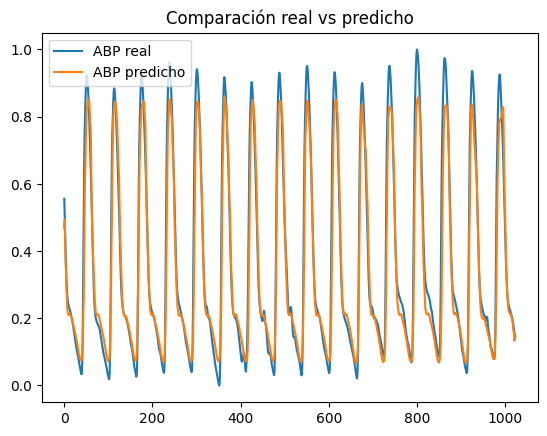

In [11]:
loss, mae = model.evaluate(X_test, Y_test)
print(f"MAE: {mae:.4f}")

# Ejemplo de predicción
i = 0
pred = model.predict(X_test[i:i+1])[0].squeeze()
plt.plot(Y_test[i].squeeze(), label='ABP real')
plt.plot(pred, label='ABP predicho')
plt.legend()
plt.title("Comparación real vs predicho")
plt.show()